In [1]:
%matplotlib inline
%autosave 60

import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import random
import sys
sys.path.append('../boresightUtils/')

from astropy.io import fits
from astropy.time import Time
from scipy.stats import sigmaclip
from astropy import units as u
from boresightUtils import *

Autosaving every 60 seconds


In [4]:
# imageDir = '/home/adriansh/Pictures/work/lsst/startracker/fitsFiles' # Adrian local
imageDir = '/home/adriansh95/DATA/starTracker/tmaTests/procFits/' # Adrian summit
cam = 'GC101'
date = '20221122'
stems = ''
globstr = os.path.join(imageDir, f'{cam}*{date}*{stems}*.fits')
files = sorted(glob.glob(globstr))
print(files)

['/home/adriansh95/DATA/starTracker/tmaTests/procFits/GC101_O_20221122_000001.fits', '/home/adriansh95/DATA/starTracker/tmaTests/procFits/GC101_O_20221122_000003.fits', '/home/adriansh95/DATA/starTracker/tmaTests/procFits/GC101_O_20221122_000004.fits', '/home/adriansh95/DATA/starTracker/tmaTests/procFits/GC101_O_20221122_000006.fits', '/home/adriansh95/DATA/starTracker/tmaTests/procFits/GC101_O_20221122_000030.fits', '/home/adriansh95/DATA/starTracker/tmaTests/procFits/GC101_O_20221122_000031.fits', '/home/adriansh95/DATA/starTracker/tmaTests/procFits/GC101_O_20221122_000032.fits', '/home/adriansh95/DATA/starTracker/tmaTests/procFits/GC101_O_20221122_000033.fits', '/home/adriansh95/DATA/starTracker/tmaTests/procFits/GC101_O_20221122_000034.fits', '/home/adriansh95/DATA/starTracker/tmaTests/procFits/GC101_O_20221122_000035.fits', '/home/adriansh95/DATA/starTracker/tmaTests/procFits/GC101_O_20221122_000036.fits', '/home/adriansh95/DATA/starTracker/tmaTests/procFits/GC101_O_20221122_00003

In [42]:
driftIm0 = 'GC101_O_20221122_000062.fits'
driftIm1 = 'GC101_O_20221122_000063.fits'
arcIm = 'GC101_O_20221122_000044.fits'

with fits.open(os.path.join(imageDir, driftIm0)) as hdu:
    dIm0 = hdu[1].data
    t0 = Time(hdu[0].header['DATE-BEG'])
       
with fits.open(os.path.join(imageDir, driftIm1)) as hdu:
    dIm1 = hdu[1].data
    t1 = Time(hdu[0].header['DATE-BEG'])
    phi = hdu[0].header['AZEND']

with fits.open(os.path.join(imageDir, arcIm)) as hdu:
    arcImage = hdu[1].data
    azStart = hdu[0].header['AZSTART']
    azEnd = hdu[0].header['AZEND']
    arcT0 = Time(hdu[0].header['DATE-BEG'])
    arcT1 = Time(hdu[0].header['DATE-END'])
   
thetaInit = azStart - phi
dt = t1 - t0
dt = dt.to(u.s).value
totalDrift = measure_drift(dIm0, dIm1)
driftRateRC = totalDrift / dt
driftRate = np.array([[driftRateRC[1]], [-driftRateRC[0]]])

dTheta = azEnd - azStart
arcDt = arcT1 - arcT0
arcDt = arcDt.to(u.s).value
slewRate = dTheta / arcDt

In [43]:
rng = np.random.default_rng()
height, width = arcImage.shape
xMu = width / 2
yMu = height / 2

configDict = {
    'expTime': arcDt,
    'slewRate': slewRate,
    'driftVel': driftRate,
    'threshold': 0.3,
    'rng': rng,
    'imageWidth': width,
    'imageHeight': height,
    'gaussianBlurSigma': 1,
    'xMu': xMu,
    'yMu': yMu,
    'pointingSigma': 100,
    'nStars': 25,
    }

biases = calculate_drift_bias(configDict, thetaInit=thetaInit)
bias = biases.mean(axis=0)

In [44]:
print(biases)

[[-8.06994163  9.98981519]
 [-8.53593814 10.3112189 ]
 [-8.298821    9.96407856]
 [-7.89801397  8.97206331]
 [-7.93078399  9.43933153]
 [-7.59129304  9.36022916]
 [-7.07625202  8.49607641]
 [-8.43433167  9.22143084]
 [-7.520162   10.48249492]
 [-7.90824428  9.31306947]]


In [45]:
c, low, high = sigmaclip(arcImage)
mean = c.mean()
std = c.std()
tArcImage = np.where(arcImage > mean+5*std, 1, 0)
nTrials = 10
boresights = np.zeros((nTrials, 2))

for i in range(nTrials):
    boresights[i] = find_boresight_naive(tArcImage)

In [46]:
print(boresights)

[[1250.7494599  1572.88103688]
 [1246.03264137 1570.58942882]
 [1250.55638837 1567.82448459]
 [1252.76597549 1569.58244073]
 [1253.83742348 1572.22952371]
 [1251.8204121  1570.9819872 ]
 [1251.11519111 1573.28318476]
 [1251.29894723 1573.02239123]
 [1249.64754052 1572.51132937]
 [1247.09031594 1570.42782918]]


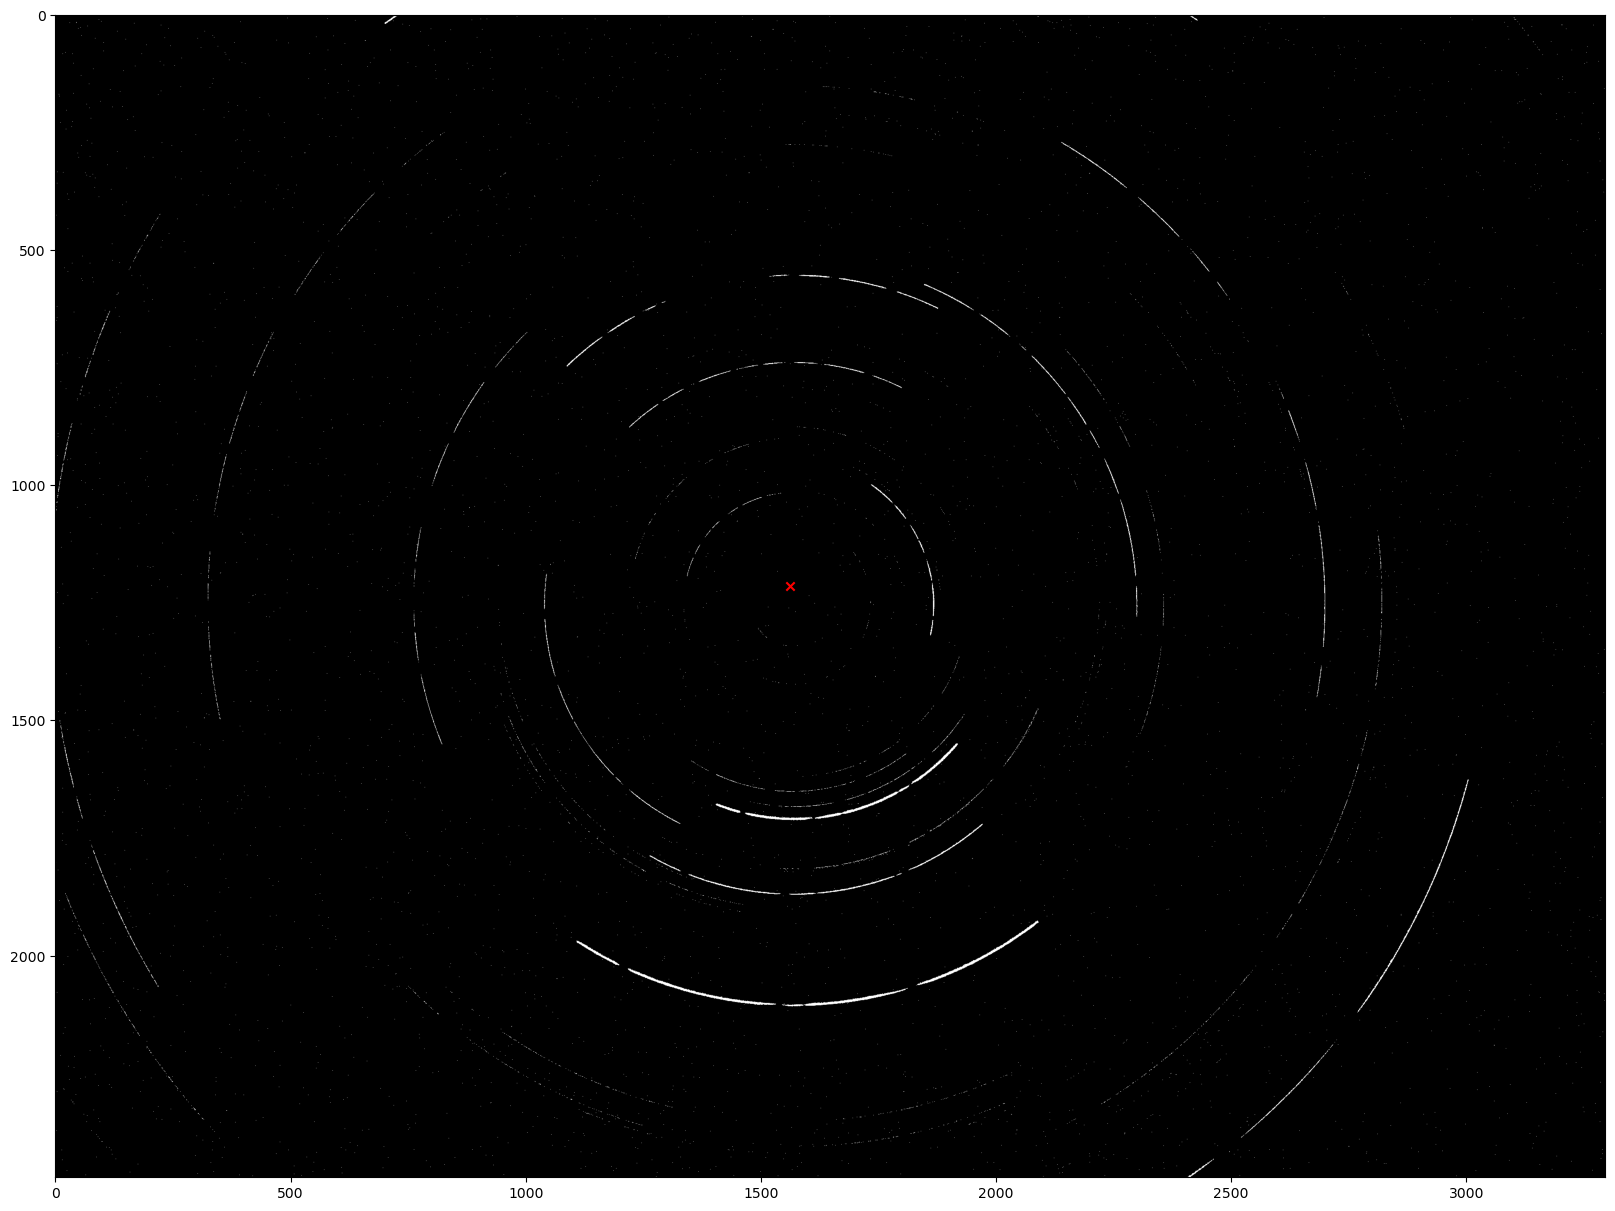

[1258.41780773 1561.77838282]


In [47]:
boresight = boresights.mean(axis=0) - bias
plot_arc_image(tArcImage, boresight=boresight)
print(boresight)

In [10]:
print(arcDt)

11.160000000005965
